# Importing Libraries

In [1]:
import numpy as np

from pygenn import genn_model
from pygenn import genn_wrapper

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import time
from struct import unpack
from gzip import decompress
from urllib import request
import seaborn as sns

# Creating and Visualizing Dataset

In [2]:
# Functions for creating the Dataset
def get_image_data(url, filename, correct_magic):
    if os.path.exists(filename):
        print("Loading existing data")
        return np.load(filename)
    else:
        print("Downloading dataset")
        with request.urlopen(url) as response:
            print("Decompressing dataset")
            image_data = decompress(response.read())

            # Unpack header from first 16 bytes of buffer
            magic, num_items, num_rows, num_cols = unpack('>IIII', image_data[:16])
            assert magic == correct_magic
            assert num_rows == 28
            assert num_cols == 28

            # Convert remainder of buffer to numpy bytes
            image_data_np = np.frombuffer(image_data[16:], dtype=np.uint8)

            # Reshape data into individual images
            image_data_np = np.reshape(image_data_np, (num_items, num_rows * num_cols))

            # Write to disk
            np.save(filename, image_data_np)

            return image_data_np

def get_label_data(url, filename, correct_magic):
    if os.path.exists(filename):
        print("Loading existing data")
        return np.load(filename)
    else:
        print("Downloading dataset")
        with request.urlopen(url) as response:
            print("Decompressing dataset")
            label_data = decompress(response.read())

            # Unpack header from first 8 bytes of buffer
            magic, num_items = unpack('>II', label_data[:8])
            assert magic == correct_magic

            # Convert remainder of buffer to numpy bytes
            label_data_np = np.frombuffer(label_data[8:], dtype=np.uint8)
            assert label_data_np.shape == (num_items,)

            # Write to disk
            np.save(filename, label_data_np)

            return label_data_np

def get_training_data():
    images = np.load('./training_images.npy') if os.path.exists('./training_images.npy') else get_image_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "training_images.npy", 2051)
    labels = np.load('./training_labels.npy') if os.path.exists('./training_labels.npy') else get_label_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz", "training_labels.npy", 2049)
    assert images.shape[0] == labels.shape[0]

    return images, labels

def get_testing_data():
    images = np.load('./testing_images.npy') if os.path.exists('./testing_images.npy') else get_image_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "testing_images.npy", 2051) 
    labels = np.load('./testing_labels.npy') if os.path.exists('./testing_labels.npy') else get_label_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz", "testing_labels.npy", 2049)
    assert images.shape[0] == labels.shape[0]

    return images, labels

In [3]:
# Creating the Dataset
train_images, train_labels = get_training_data()
test_images, test_labels = get_testing_data()

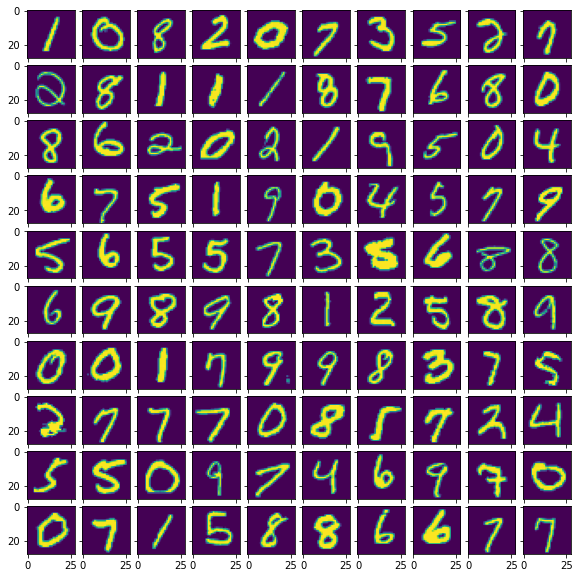

In [4]:
# Plotting Random images from training dataset
nRow = 10
nCol = 10
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(nRow, nCol),  # creates nrow x ncol grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
random_imgs = [train_images[np.random.randint(train_images.shape[0])].reshape(28,28) for i in range(nRow*nCol)]
    
for ax, im in zip(grid, random_imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)#,cmap=cmap.get_cmap('hot_r'))
plt.show()

# Creating the Model

Model has 3 layers:  
(784 neurons)--StaticSynapse-->(128 neurons)--STDP-->(10 neurons)  

## Setting up Parameters

In [5]:
# Network parameters
OUTPUT_SHAPE = 10

# Simulation parameters
TIMESTEP = 1.0
PRESENT_TIMESTEPS = 100
INPUT_CURRENT_SCALE = 1.0 / 100.0

# Neuron parameters
IF_PARAMS = {"Vthr": 5.0}

#Synapse parameters
G_MIN = -2
G_MAX = 2
A_PLUS = 0.00001 # 0.1
A_MINUS = 10 * A_PLUS # 1.05
TAU_PLUS = 5 # 20
TAU_MINUS = int(8 * TAU_PLUS) # 1 
# stdp_params = {"tauPlus": 20.0, "tauMinus": 20.0, "aPlus": A_PLUS, "aMinus": A_MINUS, "wMin": 0.0, "wMax": G_MAX} # Decalred later
post_syn_params = {"tau": 5.0}

## Setting up Initialization Parameters

In [6]:
# Neuron parameters
if_init = {"V": 0.0, "SpikeCount":0}

# STDP parameters
# Initialized later
# stdp_init = {"g": genn_model.init_var("Uniform", {"min": 0.0, "max": G_MAX})}
# stdp_pre_init = {"preTrace": 0.0}
# stdp_post_init = {"postTrace": 0.0}

## Creating the model

In [7]:
# Create GeNN model
model = genn_model.GeNNModel("float", "STDP_Additive_train")
model.dT = TIMESTEP

## Loading weights for Static Synapse

In [8]:
weights = np.load("weights_0_1.npy")
print(weights.shape)

(784, 128)


## Neurons

In [9]:
# Custom Neuron Models

# IF neuron model
if_model = genn_model.create_custom_neuron_class(
    "if_model",
    param_names=["Vthr"],
    var_name_types=[("V", "scalar"), ("SpikeCount", "unsigned int")],
    sim_code="$(V) += $(Isyn) * DT;",
    reset_code="""
    $(V) = 0.0;
    $(SpikeCount)++;
    """,
    threshold_condition_code="$(V) >= $(Vthr)")

In [10]:
# Input layer
neuron_layers = [model.add_neuron_population("l0", weights.shape[0], 
                                             if_model, IF_PARAMS, if_init)]
# First layer
neuron_layers.append(model.add_neuron_population("l1", weights.shape[1], 
                                                if_model, IF_PARAMS, if_init))
# Second layer as 10 layers each containing 1 neuron
l2 = []
for i in range(OUTPUT_SHAPE):
    l2.append(model.add_neuron_population("l2_"+str(i), 1, 
                                                    if_model, IF_PARAMS, if_init))
neuron_layers.append(l2)

## Current source

In [11]:
# Current source model which injects current with a magnitude specified by a state variable
cs_model = genn_model.create_custom_current_source_class(
    "cs_model",
    var_name_types=[("magnitude", "scalar")],
    injection_code="$(injectCurrent, $(magnitude));")

## Synapses

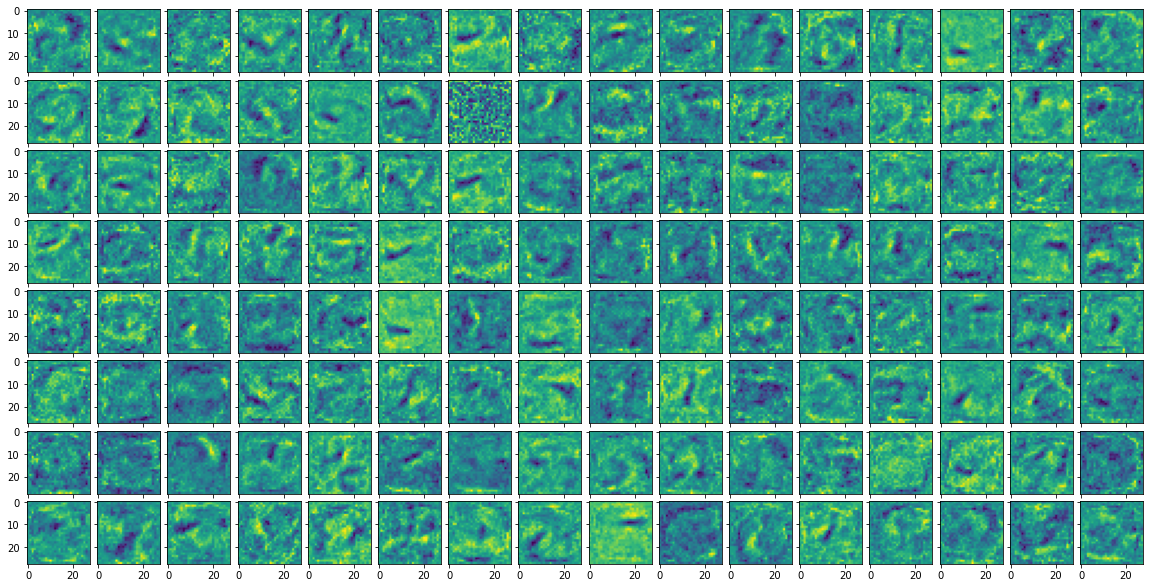

In [12]:
# Visualizing weights of StaticSynapse
nRow = 8
nCol = 16
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(nRow, nCol),  # creates nrow x ncol grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
wt_imgs = [weights.transpose()[i].reshape(28,28) for i in range(nRow*nCol)]
    
for ax, im in zip(grid, wt_imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [13]:
# STDP synapse with additive weight dependence
# Output label is the label corresponding to the output neuron this synapse is connected to
# Current label is the label of the example currently being shown during training
stdp_additive = genn_model.create_custom_weight_update_class(
    "STDPAdditive",
    param_names=["tauPlus", "tauMinus", "aPlus", "aMinus", "wMin", "wMax","output_label"],
    var_name_types=[("g", "scalar"),("current_label","scalar")],
    pre_var_name_types=[("preTrace", "scalar"),("current_label_pre","scalar")],
    post_var_name_types=[("postTrace", "scalar"),("current_label_post","scalar")],
    derived_params=[("aPlusScaled", genn_model.create_dpf_class(lambda pars, dt: pars[2] * (pars[5] - pars[4]))()),
                    ("aMinusScaled", genn_model.create_dpf_class(lambda pars, dt: pars[3] * (pars[5] - pars[4]))())],

    sim_code=
        """
        if($(output_label) == $(current_label)) {
            $(addToInSyn, $(g));
            const scalar dt = $(t) - $(sT_post);
            if(dt > 0) {
                const scalar timing = exp(-dt / $(tauMinus));
                const scalar newWeight = $(g) - ($(aMinusScaled) * $(postTrace) * timing);
                $(g) = fmin($(wMax), fmax($(wMin), newWeight));
            }
        }
        """,

    learn_post_code=
        """
        if($(output_label) == $(current_label)) {
            const scalar dt = $(t) - $(sT_pre);
            if(dt > 0) {
                const scalar timing = exp(-dt / $(tauPlus));
                const scalar newWeight = $(g) + ($(aPlusScaled) * $(preTrace) * timing);
                $(g) = fmin($(wMax), fmax($(wMin), newWeight));
            }
        }
        """,

    pre_spike_code=
        """
        if($(output_label) == $(current_label_pre)) {
            const scalar dt = $(t) - $(sT_pre);
            $(preTrace) = $(preTrace) * exp(-dt / $(tauPlus)) + 1.0;
        }
        """,

    post_spike_code=
        """
        if($(output_label) == $(current_label_post)) {
            const scalar dt = $(t) - $(sT_post);
            $(postTrace) = $(postTrace) * exp(-dt / $(tauMinus)) + 1.0;
        }
        """,

    is_pre_spike_time_required=True,
    is_post_spike_time_required=True)

In [14]:
# 0 -> 1
model.add_synapse_population(
        "synapse0", "DENSE_INDIVIDUALG", genn_wrapper.NO_DELAY,
        neuron_layers[0], neuron_layers[1],
        "StaticPulse", {}, {"g": weights.flatten()}, {}, {},
        "DeltaCurr", {}, {})
# 1 -> 2
# 10 STDP synapse groups for each output neuron
stdp_synapse = []
for i in range(OUTPUT_SHAPE):
    stdp_params = {"tauPlus": TAU_PLUS, "tauMinus": TAU_MINUS, "aPlus": A_PLUS, "aMinus": A_MINUS, "wMin": G_MIN, "wMax": G_MAX, "output_label":i}
    stdp_init = {"g": genn_model.init_var("Uniform", {"min": G_MIN, "max": G_MAX}), "current_label":0}
    stdp_pre_init = {"preTrace": 0.0, "current_label_pre":0}
    stdp_post_init = {"postTrace": 0.0, "current_label_post":0}
    stdp_synapse.append(model.add_synapse_population("input_additive_"+str(i), "DENSE_INDIVIDUALG", genn_wrapper.NO_DELAY,
        neuron_layers[1], neuron_layers[2][i],
        stdp_additive, stdp_params, stdp_init, stdp_pre_init, stdp_post_init,
        "ExpCurr", post_syn_params, {})
                       )

In [15]:
# Create current source to deliver input to first layers of neurons
current_input = model.add_current_source("current_input", cs_model,
                                         "l0" , {}, {"magnitude": 0.0})

In [16]:
# Build and load our model
model.build()
model.load()

# Training

In [17]:
# Get initial weights
stdp_initial_wts = np.copy(stdp_synapse[0].get_var_values("g").reshape(128,1))
for i in range(1,OUTPUT_SHAPE):
    stdp_initial_wts = np.append(stdp_initial_wts,np.copy(stdp_synapse[i].get_var_values("g").reshape(128,1)),axis=1)

In [18]:
# Load testing data
training_images = np.load("training_images.npy")
training_labels = np.load("training_labels.npy")

# Check dimensions match network
assert training_images.shape[1] == weights.shape[0]
assert np.max(training_labels) == (OUTPUT_SHAPE - 1)

In [19]:
# Get views to efficiently access state variables
current_input_magnitude = current_input.vars["magnitude"].view
output_spike_count = []
for i in range(OUTPUT_SHAPE):
    output_spike_count.append(neuron_layers[-1][i].vars["SpikeCount"].view)
layer_voltages = [l.vars["V"].view for l in neuron_layers[:-1]]
for i in range(OUTPUT_SHAPE):
    layer_voltages.append(neuron_layers[-1][i].vars["V"].view)

In [20]:
# Get views for current labels
current_labels = []
current_labels_pre = []
current_labels_post = []
for i in range(OUTPUT_SHAPE):
    current_labels.append(stdp_synapse[i].vars["current_label"].view)
    current_labels_pre.append(stdp_synapse[i].pre_vars["current_label_pre"].view)
    current_labels_post.append(stdp_synapse[i].post_vars["current_label_post"].view)

In [21]:
# Simulate
num_correct = 0
training_accs = []
while model.timestep < (PRESENT_TIMESTEPS * training_images.shape[0]): # training_images.shape[0]
    # Calculate the timestep within the presentation
    timestep_in_example = model.timestep % PRESENT_TIMESTEPS
    example = int(model.timestep // PRESENT_TIMESTEPS)
    example_label = training_labels[example]

    # If this is the first timestep of presenting the example
    if timestep_in_example == 0:
        for i in range(OUTPUT_SHAPE):
            # Manually set the current labels
            current_labels[i][:] = example_label
            current_labels_pre[i][:] = example_label
            current_labels_post[i][:] = example_label
            # Upload
            model.push_var_to_device(stdp_synapse[i].name,"current_label")
            model.push_var_to_device(stdp_synapse[i].name,"current_label_pre")
            model.push_var_to_device(stdp_synapse[i].name,"current_label_post")
            
        current_input_magnitude[:] = training_images[example] * INPUT_CURRENT_SCALE
        model.push_var_to_device("current_input", "magnitude")

        # Loop through all layers and their corresponding voltage views
        for l, v in zip(neuron_layers[:2], layer_voltages[:2]):
            # Manually 'reset' voltage
            v[:] = 0.0

            # Upload
            model.push_var_to_device(l.name, "V")
        for l,v in zip(neuron_layers[-1],layer_voltages[2:]):
            # Manually 'reset' voltage
            v[:] = 0.0

            # Upload
            model.push_var_to_device(l.name, "V")

        # Zero spike count
        for i in range(OUTPUT_SHAPE):
            output_spike_count[i][:] = 0.0
            model.push_var_to_device(neuron_layers[-1][i].name, "SpikeCount")

    # Advance simulation
    model.step_time()

    # If this is the LAST timestep of presenting the example
    if timestep_in_example == (PRESENT_TIMESTEPS - 1):
        if example%5000==0 and example!=0:
            print("Examples seen = " + str(example))

Examples seen = 5000
Examples seen = 10000
Examples seen = 15000
Examples seen = 20000
Examples seen = 25000
Examples seen = 30000
Examples seen = 35000
Examples seen = 40000
Examples seen = 45000
Examples seen = 50000
Examples seen = 55000


In [22]:
# Storing weights
for i in range(OUTPUT_SHAPE):
    model.pull_var_from_device("input_additive_"+str(i), "g")
weights = [weights]
weights.append(stdp_synapse[0].get_var_values("g").reshape(weights[0].shape[1],1))
for i in range(1,OUTPUT_SHAPE):
    weights[1] = np.append(weights[1],stdp_synapse[i].get_var_values("g").reshape(weights[0].shape[1],1),axis=1)
# sns.distplot(weights[0].flatten())
# sns.distplot(weights[1].flatten())

In [23]:
# Printing Initial Weights
stdp_initial_wts

array([[-1.5310057 ,  1.0008278 , -1.9105743 , ..., -0.91454303,
        -1.6504146 , -1.6990395 ],
       [-0.90649784,  0.9816122 ,  1.685421  , ..., -0.8753195 ,
        -1.7356285 ,  0.82859206],
       [ 0.6190009 , -1.124935  ,  1.086407  , ...,  1.5767665 ,
         0.43757582, -0.1748426 ],
       ...,
       [ 0.6336279 , -1.5133862 ,  0.12935734, ..., -1.634305  ,
         0.35447025,  1.118604  ],
       [ 1.9422572 ,  1.2698753 , -1.7829204 , ..., -1.8544667 ,
         1.6274898 ,  0.7168889 ],
       [-0.32202494,  0.2720666 , -0.17365026, ..., -1.344243  ,
        -1.4755003 ,  0.8484323 ]], dtype=float32)

In [24]:
# Printing trained weights
weights[1]

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

In [28]:
# sns.distplot(weights[1].flatten())

# Testing

In [26]:
# Create GeNN model
model = genn_model.GeNNModel("float", "STDP_Additive_test")
model.dT = TIMESTEP

#neurons
neuron_layers = [model.add_neuron_population("l0", weights[0].shape[0], 
                                             if_model, IF_PARAMS, if_init)]
neuron_layers.append(model.add_neuron_population("l1", weights[0].shape[1], 
                                                if_model, IF_PARAMS, if_init))
neuron_layers.append(model.add_neuron_population("l2", OUTPUT_SHAPE, 
                                                if_model, IF_PARAMS, if_init))

#synapses
model.add_synapse_population(
        "synapse0", "DENSE_INDIVIDUALG", genn_wrapper.NO_DELAY,
        neuron_layers[0], neuron_layers[1],
        "StaticPulse", {}, {"g": weights[0].flatten()}, {}, {},
        "DeltaCurr", {}, {})
model.add_synapse_population(
        "synapse1", "DENSE_INDIVIDUALG", genn_wrapper.NO_DELAY,
        neuron_layers[1], neuron_layers[2],
        "StaticPulse", {}, {"g": weights[1].flatten()}, {}, {},
        "DeltaCurr", {}, {})

# Create current source to deliver input to first layers of neurons
current_input = model.add_current_source("current_input", cs_model,
                                         "l0" , {}, {"magnitude": 0.0})

# Build and load our model
model.build()
model.load()

# Load testing data
testing_images = np.load("testing_images.npy")
testing_labels = np.load("testing_labels.npy")

# Check dimensions match network
assert testing_images.shape[1] == weights[0].shape[0]
assert np.max(testing_labels) == (OUTPUT_SHAPE - 1)

# Get views to efficiently access state variables
current_input_magnitude = current_input.vars["magnitude"].view
output_spike_count = neuron_layers[-1].vars["SpikeCount"].view
layer_voltages = [l.vars["V"].view for l in neuron_layers]

# Simulate
num_correct = 0
predicted_labels = []
while model.timestep < (PRESENT_TIMESTEPS * testing_images.shape[0]):
    # Calculate the timestep within the presentation
    timestep_in_example = model.timestep % PRESENT_TIMESTEPS
    example = int(model.timestep // PRESENT_TIMESTEPS)

    # If this is the first timestep of presenting the example
    if timestep_in_example == 0:
        current_input_magnitude[:] = testing_images[example] * INPUT_CURRENT_SCALE
        model.push_var_to_device("current_input", "magnitude")

        # Loop through all layers and their corresponding voltage views
        for l, v in zip(neuron_layers, layer_voltages):
            # Manually 'reset' voltage
            v[:] = 0.0

            # Upload
            model.push_var_to_device(l.name, "V")

        # Zero spike count
        output_spike_count[:] = 0
        model.push_var_to_device(neuron_layers[-1].name, "SpikeCount")

    # Advance simulation
    model.step_time()

    # If this is the LAST timestep of presenting the example
    if timestep_in_example == (PRESENT_TIMESTEPS - 1):
        # Download spike count from last layer
        model.pull_var_from_device(neuron_layers[-1].name, "SpikeCount")

        # Find which neuron spiked the most to get prediction
        predicted_label = np.argmax(output_spike_count)
        true_label = testing_labels[example]
        predicted_labels.append(predicted_label)

        print("\tExample=%u, true label=%u, predicted label=%u" % (example,
                                                                   true_label,
                                                                   predicted_label))

        if predicted_label == true_label:
            num_correct += 1

	Example=0, true label=7, predicted label=3
	Example=1, true label=2, predicted label=0
	Example=2, true label=1, predicted label=1
	Example=3, true label=0, predicted label=0
	Example=4, true label=4, predicted label=0
	Example=5, true label=1, predicted label=2
	Example=6, true label=4, predicted label=2
	Example=7, true label=9, predicted label=0
	Example=8, true label=5, predicted label=0
	Example=9, true label=9, predicted label=0
	Example=10, true label=0, predicted label=0
	Example=11, true label=6, predicted label=0
	Example=12, true label=9, predicted label=3
	Example=13, true label=0, predicted label=0
	Example=14, true label=1, predicted label=1
	Example=15, true label=5, predicted label=3
	Example=16, true label=9, predicted label=0
	Example=17, true label=7, predicted label=0
	Example=18, true label=3, predicted label=0
	Example=19, true label=4, predicted label=4
	Example=20, true label=9, predicted label=4
	Example=21, true label=6, predicted label=2
	Example=22, true la

	Example=245, true label=3, predicted label=0
	Example=246, true label=0, predicted label=0
	Example=247, true label=4, predicted label=2
	Example=248, true label=4, predicted label=0
	Example=249, true label=2, predicted label=1
	Example=250, true label=4, predicted label=0
	Example=251, true label=1, predicted label=1
	Example=252, true label=9, predicted label=2
	Example=253, true label=5, predicted label=3
	Example=254, true label=7, predicted label=2
	Example=255, true label=7, predicted label=0
	Example=256, true label=2, predicted label=0
	Example=257, true label=8, predicted label=1
	Example=258, true label=2, predicted label=0
	Example=259, true label=6, predicted label=0
	Example=260, true label=8, predicted label=0
	Example=261, true label=5, predicted label=0
	Example=262, true label=7, predicted label=2
	Example=263, true label=7, predicted label=4
	Example=264, true label=9, predicted label=2
	Example=265, true label=1, predicted label=3
	Example=266, true label=8, predic

	Example=577, true label=3, predicted label=3
	Example=578, true label=3, predicted label=1
	Example=579, true label=7, predicted label=5
	Example=580, true label=8, predicted label=3
	Example=581, true label=0, predicted label=0
	Example=582, true label=8, predicted label=0
	Example=583, true label=2, predicted label=3
	Example=584, true label=1, predicted label=1
	Example=585, true label=7, predicted label=2
	Example=586, true label=0, predicted label=0
	Example=587, true label=6, predicted label=0
	Example=588, true label=5, predicted label=0
	Example=589, true label=4, predicted label=4
	Example=590, true label=3, predicted label=0
	Example=591, true label=8, predicted label=2
	Example=592, true label=0, predicted label=0
	Example=593, true label=9, predicted label=0
	Example=594, true label=6, predicted label=0
	Example=595, true label=3, predicted label=0
	Example=596, true label=8, predicted label=0
	Example=597, true label=0, predicted label=0
	Example=598, true label=9, predic

	Example=889, true label=1, predicted label=0
	Example=890, true label=3, predicted label=0
	Example=891, true label=2, predicted label=1
	Example=892, true label=2, predicted label=0
	Example=893, true label=9, predicted label=3
	Example=894, true label=3, predicted label=1
	Example=895, true label=0, predicted label=0
	Example=896, true label=0, predicted label=0
	Example=897, true label=5, predicted label=3
	Example=898, true label=7, predicted label=3
	Example=899, true label=8, predicted label=0
	Example=900, true label=1, predicted label=1
	Example=901, true label=4, predicted label=4
	Example=902, true label=4, predicted label=4
	Example=903, true label=6, predicted label=0
	Example=904, true label=0, predicted label=0
	Example=905, true label=2, predicted label=0
	Example=906, true label=9, predicted label=4
	Example=907, true label=1, predicted label=4
	Example=908, true label=4, predicted label=4
	Example=909, true label=7, predicted label=5
	Example=910, true label=4, predic

	Example=1218, true label=0, predicted label=0
	Example=1219, true label=8, predicted label=2
	Example=1220, true label=0, predicted label=0
	Example=1221, true label=5, predicted label=0
	Example=1222, true label=4, predicted label=2
	Example=1223, true label=0, predicted label=0
	Example=1224, true label=2, predicted label=0
	Example=1225, true label=8, predicted label=2
	Example=1226, true label=7, predicted label=2
	Example=1227, true label=2, predicted label=2
	Example=1228, true label=9, predicted label=1
	Example=1229, true label=8, predicted label=3
	Example=1230, true label=4, predicted label=0
	Example=1231, true label=0, predicted label=0
	Example=1232, true label=9, predicted label=4
	Example=1233, true label=5, predicted label=0
	Example=1234, true label=8, predicted label=0
	Example=1235, true label=5, predicted label=0
	Example=1236, true label=1, predicted label=1
	Example=1237, true label=2, predicted label=1
	Example=1238, true label=1, predicted label=1
	Example=1239

	Example=1505, true label=7, predicted label=1
	Example=1506, true label=2, predicted label=1
	Example=1507, true label=7, predicted label=7
	Example=1508, true label=9, predicted label=0
	Example=1509, true label=4, predicted label=0
	Example=1510, true label=5, predicted label=2
	Example=1511, true label=4, predicted label=3
	Example=1512, true label=9, predicted label=0
	Example=1513, true label=3, predicted label=3
	Example=1514, true label=2, predicted label=0
	Example=1515, true label=1, predicted label=1
	Example=1516, true label=4, predicted label=2
	Example=1517, true label=0, predicted label=0
	Example=1518, true label=2, predicted label=0
	Example=1519, true label=3, predicted label=0
	Example=1520, true label=7, predicted label=0
	Example=1521, true label=5, predicted label=0
	Example=1522, true label=7, predicted label=2
	Example=1523, true label=8, predicted label=0
	Example=1524, true label=8, predicted label=1
	Example=1525, true label=5, predicted label=0
	Example=1526

	Example=1738, true label=3, predicted label=0
	Example=1739, true label=0, predicted label=0
	Example=1740, true label=8, predicted label=0
	Example=1741, true label=7, predicted label=1
	Example=1742, true label=3, predicted label=0
	Example=1743, true label=9, predicted label=4
	Example=1744, true label=6, predicted label=2
	Example=1745, true label=9, predicted label=0
	Example=1746, true label=3, predicted label=2
	Example=1747, true label=5, predicted label=0
	Example=1748, true label=0, predicted label=0
	Example=1749, true label=2, predicted label=0
	Example=1750, true label=7, predicted label=3
	Example=1751, true label=4, predicted label=0
	Example=1752, true label=5, predicted label=3
	Example=1753, true label=1, predicted label=1
	Example=1754, true label=7, predicted label=1
	Example=1755, true label=5, predicted label=0
	Example=1756, true label=8, predicted label=1
	Example=1757, true label=0, predicted label=0
	Example=1758, true label=8, predicted label=0
	Example=1759

	Example=2077, true label=5, predicted label=0
	Example=2078, true label=5, predicted label=0
	Example=2079, true label=6, predicted label=4
	Example=2080, true label=3, predicted label=1
	Example=2081, true label=0, predicted label=0
	Example=2082, true label=2, predicted label=1
	Example=2083, true label=3, predicted label=1
	Example=2084, true label=4, predicted label=1
	Example=2085, true label=2, predicted label=0
	Example=2086, true label=3, predicted label=0
	Example=2087, true label=0, predicted label=0
	Example=2088, true label=9, predicted label=4
	Example=2089, true label=9, predicted label=5
	Example=2090, true label=4, predicted label=1
	Example=2091, true label=7, predicted label=0
	Example=2092, true label=2, predicted label=7
	Example=2093, true label=8, predicted label=0
	Example=2094, true label=4, predicted label=2
	Example=2095, true label=7, predicted label=0
	Example=2096, true label=0, predicted label=0
	Example=2097, true label=6, predicted label=2
	Example=2098

	Example=2359, true label=1, predicted label=1
	Example=2360, true label=6, predicted label=2
	Example=2361, true label=9, predicted label=1
	Example=2362, true label=8, predicted label=0
	Example=2363, true label=4, predicted label=0
	Example=2364, true label=3, predicted label=0
	Example=2365, true label=7, predicted label=3
	Example=2366, true label=1, predicted label=1
	Example=2367, true label=6, predicted label=0
	Example=2368, true label=4, predicted label=0
	Example=2369, true label=5, predicted label=0
	Example=2370, true label=0, predicted label=0
	Example=2371, true label=4, predicted label=0
	Example=2372, true label=7, predicted label=0
	Example=2373, true label=4, predicted label=4
	Example=2374, true label=2, predicted label=1
	Example=2375, true label=4, predicted label=1
	Example=2376, true label=0, predicted label=0
	Example=2377, true label=7, predicted label=4
	Example=2378, true label=0, predicted label=0
	Example=2379, true label=1, predicted label=1
	Example=2380

	Example=2534, true label=3, predicted label=0
	Example=2535, true label=6, predicted label=0
	Example=2536, true label=0, predicted label=0
	Example=2537, true label=4, predicted label=2
	Example=2538, true label=9, predicted label=2
	Example=2539, true label=7, predicted label=4
	Example=2540, true label=5, predicted label=0
	Example=2541, true label=1, predicted label=1
	Example=2542, true label=6, predicted label=2
	Example=2543, true label=8, predicted label=0
	Example=2544, true label=9, predicted label=2
	Example=2545, true label=5, predicted label=2
	Example=2546, true label=5, predicted label=5
	Example=2547, true label=7, predicted label=0
	Example=2548, true label=9, predicted label=0
	Example=2549, true label=3, predicted label=0
	Example=2550, true label=8, predicted label=0
	Example=2551, true label=3, predicted label=1
	Example=2552, true label=8, predicted label=0
	Example=2553, true label=1, predicted label=1
	Example=2554, true label=5, predicted label=5
	Example=2555

	Example=2918, true label=2, predicted label=0
	Example=2919, true label=5, predicted label=0
	Example=2920, true label=6, predicted label=2
	Example=2921, true label=3, predicted label=0
	Example=2922, true label=5, predicted label=0
	Example=2923, true label=9, predicted label=4
	Example=2924, true label=3, predicted label=1
	Example=2925, true label=5, predicted label=0
	Example=2926, true label=9, predicted label=3
	Example=2927, true label=3, predicted label=0
	Example=2928, true label=1, predicted label=1
	Example=2929, true label=9, predicted label=4
	Example=2930, true label=5, predicted label=0
	Example=2931, true label=3, predicted label=3
	Example=2932, true label=0, predicted label=0
	Example=2933, true label=6, predicted label=0
	Example=2934, true label=9, predicted label=0
	Example=2935, true label=8, predicted label=2
	Example=2936, true label=4, predicted label=0
	Example=2937, true label=0, predicted label=0
	Example=2938, true label=4, predicted label=0
	Example=2939

	Example=3427, true label=6, predicted label=0
	Example=3428, true label=6, predicted label=4
	Example=3429, true label=4, predicted label=4
	Example=3430, true label=1, predicted label=1
	Example=3431, true label=4, predicted label=0
	Example=3432, true label=3, predicted label=0
	Example=3433, true label=1, predicted label=1
	Example=3434, true label=1, predicted label=1
	Example=3435, true label=2, predicted label=0
	Example=3436, true label=2, predicted label=0
	Example=3437, true label=4, predicted label=1
	Example=3438, true label=1, predicted label=1
	Example=3439, true label=0, predicted label=0
	Example=3440, true label=8, predicted label=0
	Example=3441, true label=7, predicted label=0
	Example=3442, true label=6, predicted label=0
	Example=3443, true label=3, predicted label=0
	Example=3444, true label=4, predicted label=0
	Example=3445, true label=0, predicted label=0
	Example=3446, true label=0, predicted label=0
	Example=3447, true label=6, predicted label=0
	Example=3448

	Example=3711, true label=9, predicted label=0
	Example=3712, true label=6, predicted label=0
	Example=3713, true label=7, predicted label=2
	Example=3714, true label=6, predicted label=2
	Example=3715, true label=3, predicted label=0
	Example=3716, true label=9, predicted label=1
	Example=3717, true label=3, predicted label=5
	Example=3718, true label=4, predicted label=3
	Example=3719, true label=7, predicted label=2
	Example=3720, true label=7, predicted label=2
	Example=3721, true label=7, predicted label=4
	Example=3722, true label=4, predicted label=4
	Example=3723, true label=9, predicted label=0
	Example=3724, true label=0, predicted label=0
	Example=3725, true label=6, predicted label=2
	Example=3726, true label=4, predicted label=4
	Example=3727, true label=8, predicted label=0
	Example=3728, true label=4, predicted label=3
	Example=3729, true label=2, predicted label=3
	Example=3730, true label=7, predicted label=0
	Example=3731, true label=2, predicted label=0
	Example=3732

	Example=3995, true label=3, predicted label=3
	Example=3996, true label=4, predicted label=0
	Example=3997, true label=7, predicted label=0
	Example=3998, true label=4, predicted label=0
	Example=3999, true label=9, predicted label=0
	Example=4000, true label=9, predicted label=0
	Example=4001, true label=4, predicted label=4
	Example=4002, true label=3, predicted label=1
	Example=4003, true label=6, predicted label=0
	Example=4004, true label=3, predicted label=0
	Example=4005, true label=1, predicted label=1
	Example=4006, true label=1, predicted label=1
	Example=4007, true label=7, predicted label=0
	Example=4008, true label=6, predicted label=0
	Example=4009, true label=9, predicted label=0
	Example=4010, true label=1, predicted label=1
	Example=4011, true label=8, predicted label=3
	Example=4012, true label=4, predicted label=0
	Example=4013, true label=1, predicted label=1
	Example=4014, true label=1, predicted label=1
	Example=4015, true label=9, predicted label=0
	Example=4016

	Example=4276, true label=3, predicted label=1
	Example=4277, true label=3, predicted label=0
	Example=4278, true label=0, predicted label=0
	Example=4279, true label=2, predicted label=0
	Example=4280, true label=9, predicted label=1
	Example=4281, true label=0, predicted label=0
	Example=4282, true label=0, predicted label=0
	Example=4283, true label=9, predicted label=0
	Example=4284, true label=9, predicted label=0
	Example=4285, true label=6, predicted label=0
	Example=4286, true label=0, predicted label=0
	Example=4287, true label=9, predicted label=0
	Example=4288, true label=3, predicted label=2
	Example=4289, true label=2, predicted label=2
	Example=4290, true label=8, predicted label=3
	Example=4291, true label=4, predicted label=0
	Example=4292, true label=1, predicted label=1
	Example=4293, true label=9, predicted label=0
	Example=4294, true label=9, predicted label=0
	Example=4295, true label=7, predicted label=2
	Example=4296, true label=2, predicted label=0
	Example=4297

	Example=4463, true label=5, predicted label=0
	Example=4464, true label=6, predicted label=2
	Example=4465, true label=4, predicted label=0
	Example=4466, true label=6, predicted label=0
	Example=4467, true label=7, predicted label=4
	Example=4468, true label=4, predicted label=3
	Example=4469, true label=3, predicted label=0
	Example=4470, true label=0, predicted label=0
	Example=4471, true label=7, predicted label=0
	Example=4472, true label=5, predicted label=2
	Example=4473, true label=0, predicted label=0
	Example=4474, true label=7, predicted label=0
	Example=4475, true label=4, predicted label=0
	Example=4476, true label=2, predicted label=0
	Example=4477, true label=0, predicted label=0
	Example=4478, true label=8, predicted label=3
	Example=4479, true label=9, predicted label=4
	Example=4480, true label=9, predicted label=0
	Example=4481, true label=4, predicted label=4
	Example=4482, true label=2, predicted label=0
	Example=4483, true label=4, predicted label=4
	Example=4484

	Example=4815, true label=7, predicted label=2
	Example=4816, true label=2, predicted label=3
	Example=4817, true label=8, predicted label=5
	Example=4818, true label=3, predicted label=0
	Example=4819, true label=0, predicted label=0
	Example=4820, true label=8, predicted label=0
	Example=4821, true label=7, predicted label=2
	Example=4822, true label=8, predicted label=2
	Example=4823, true label=9, predicted label=0
	Example=4824, true label=0, predicted label=0
	Example=4825, true label=8, predicted label=3
	Example=4826, true label=4, predicted label=2
	Example=4827, true label=4, predicted label=4
	Example=4828, true label=5, predicted label=3
	Example=4829, true label=8, predicted label=0
	Example=4830, true label=5, predicted label=0
	Example=4831, true label=6, predicted label=1
	Example=4832, true label=6, predicted label=2
	Example=4833, true label=3, predicted label=0
	Example=4834, true label=0, predicted label=0
	Example=4835, true label=9, predicted label=1
	Example=4836

	Example=5183, true label=8, predicted label=4
	Example=5184, true label=8, predicted label=2
	Example=5185, true label=3, predicted label=3
	Example=5186, true label=1, predicted label=1
	Example=5187, true label=5, predicted label=3
	Example=5188, true label=8, predicted label=0
	Example=5189, true label=2, predicted label=0
	Example=5190, true label=7, predicted label=2
	Example=5191, true label=4, predicted label=0
	Example=5192, true label=2, predicted label=4
	Example=5193, true label=1, predicted label=4
	Example=5194, true label=5, predicted label=4
	Example=5195, true label=4, predicted label=0
	Example=5196, true label=5, predicted label=0
	Example=5197, true label=5, predicted label=3
	Example=5198, true label=8, predicted label=4
	Example=5199, true label=6, predicted label=0
	Example=5200, true label=4, predicted label=2
	Example=5201, true label=4, predicted label=0
	Example=5202, true label=4, predicted label=0
	Example=5203, true label=1, predicted label=1
	Example=5204

	Example=5542, true label=3, predicted label=0
	Example=5543, true label=8, predicted label=0
	Example=5544, true label=1, predicted label=0
	Example=5545, true label=2, predicted label=0
	Example=5546, true label=9, predicted label=0
	Example=5547, true label=8, predicted label=0
	Example=5548, true label=8, predicted label=0
	Example=5549, true label=7, predicted label=0
	Example=5550, true label=1, predicted label=1
	Example=5551, true label=7, predicted label=2
	Example=5552, true label=1, predicted label=0
	Example=5553, true label=1, predicted label=0
	Example=5554, true label=0, predicted label=0
	Example=5555, true label=3, predicted label=0
	Example=5556, true label=4, predicted label=2
	Example=5557, true label=2, predicted label=0
	Example=5558, true label=6, predicted label=0
	Example=5559, true label=4, predicted label=2
	Example=5560, true label=7, predicted label=0
	Example=5561, true label=4, predicted label=0
	Example=5562, true label=2, predicted label=0
	Example=5563

	Example=6051, true label=2, predicted label=0
	Example=6052, true label=2, predicted label=1
	Example=6053, true label=5, predicted label=0
	Example=6054, true label=7, predicted label=0
	Example=6055, true label=9, predicted label=0
	Example=6056, true label=8, predicted label=0
	Example=6057, true label=2, predicted label=0
	Example=6058, true label=1, predicted label=1
	Example=6059, true label=3, predicted label=1
	Example=6060, true label=1, predicted label=1
	Example=6061, true label=3, predicted label=2
	Example=6062, true label=0, predicted label=0
	Example=6063, true label=1, predicted label=0
	Example=6064, true label=2, predicted label=0
	Example=6065, true label=3, predicted label=0
	Example=6066, true label=4, predicted label=0
	Example=6067, true label=5, predicted label=0
	Example=6068, true label=6, predicted label=0
	Example=6069, true label=7, predicted label=0
	Example=6070, true label=8, predicted label=0
	Example=6071, true label=9, predicted label=3
	Example=6072

	Example=6346, true label=7, predicted label=0
	Example=6347, true label=8, predicted label=0
	Example=6348, true label=8, predicted label=0
	Example=6349, true label=3, predicted label=0
	Example=6350, true label=6, predicted label=0
	Example=6351, true label=0, predicted label=0
	Example=6352, true label=2, predicted label=0
	Example=6353, true label=7, predicted label=5
	Example=6354, true label=6, predicted label=0
	Example=6355, true label=6, predicted label=2
	Example=6356, true label=1, predicted label=1
	Example=6357, true label=2, predicted label=1
	Example=6358, true label=8, predicted label=0
	Example=6359, true label=8, predicted label=0
	Example=6360, true label=7, predicted label=0
	Example=6361, true label=7, predicted label=0
	Example=6362, true label=4, predicted label=0
	Example=6363, true label=7, predicted label=0
	Example=6364, true label=7, predicted label=5
	Example=6365, true label=3, predicted label=0
	Example=6366, true label=7, predicted label=2
	Example=6367

	Example=6804, true label=6, predicted label=2
	Example=6805, true label=7, predicted label=0
	Example=6806, true label=8, predicted label=0
	Example=6807, true label=9, predicted label=2
	Example=6808, true label=0, predicted label=0
	Example=6809, true label=1, predicted label=1
	Example=6810, true label=2, predicted label=1
	Example=6811, true label=3, predicted label=0
	Example=6812, true label=4, predicted label=0
	Example=6813, true label=5, predicted label=0
	Example=6814, true label=6, predicted label=0
	Example=6815, true label=7, predicted label=2
	Example=6816, true label=8, predicted label=2
	Example=6817, true label=9, predicted label=0
	Example=6818, true label=0, predicted label=0
	Example=6819, true label=1, predicted label=1
	Example=6820, true label=2, predicted label=1
	Example=6821, true label=3, predicted label=1
	Example=6822, true label=4, predicted label=2
	Example=6823, true label=5, predicted label=0
	Example=6824, true label=6, predicted label=2
	Example=6825

	Example=7672, true label=5, predicted label=0
	Example=7673, true label=5, predicted label=0
	Example=7674, true label=3, predicted label=1
	Example=7675, true label=3, predicted label=2
	Example=7676, true label=5, predicted label=0
	Example=7677, true label=7, predicted label=0
	Example=7678, true label=2, predicted label=0
	Example=7679, true label=5, predicted label=0
	Example=7680, true label=9, predicted label=3
	Example=7681, true label=6, predicted label=2
	Example=7682, true label=9, predicted label=0
	Example=7683, true label=2, predicted label=0
	Example=7684, true label=6, predicted label=0
	Example=7685, true label=2, predicted label=0
	Example=7686, true label=1, predicted label=1
	Example=7687, true label=2, predicted label=0
	Example=7688, true label=0, predicted label=0
	Example=7689, true label=8, predicted label=4
	Example=7690, true label=3, predicted label=0
	Example=7691, true label=8, predicted label=1
	Example=7692, true label=3, predicted label=0
	Example=7693

	Example=7850, true label=5, predicted label=0
	Example=7851, true label=6, predicted label=0
	Example=7852, true label=7, predicted label=0
	Example=7853, true label=8, predicted label=0
	Example=7854, true label=9, predicted label=0
	Example=7855, true label=0, predicted label=0
	Example=7856, true label=1, predicted label=0
	Example=7857, true label=2, predicted label=0
	Example=7858, true label=3, predicted label=0
	Example=7859, true label=5, predicted label=2
	Example=7860, true label=6, predicted label=0
	Example=7861, true label=7, predicted label=0
	Example=7862, true label=8, predicted label=0
	Example=7863, true label=9, predicted label=0
	Example=7864, true label=9, predicted label=3
	Example=7865, true label=7, predicted label=0
	Example=7866, true label=0, predicted label=0
	Example=7867, true label=9, predicted label=3
	Example=7868, true label=0, predicted label=0
	Example=7869, true label=1, predicted label=1
	Example=7870, true label=5, predicted label=5
	Example=7871

	Example=8637, true label=6, predicted label=0
	Example=8638, true label=7, predicted label=0
	Example=8639, true label=2, predicted label=0
	Example=8640, true label=9, predicted label=2
	Example=8641, true label=7, predicted label=0
	Example=8642, true label=9, predicted label=3
	Example=8643, true label=5, predicted label=0
	Example=8644, true label=6, predicted label=0
	Example=8645, true label=5, predicted label=0
	Example=8646, true label=2, predicted label=0
	Example=8647, true label=6, predicted label=0
	Example=8648, true label=2, predicted label=0
	Example=8649, true label=8, predicted label=1
	Example=8650, true label=1, predicted label=1
	Example=8651, true label=7, predicted label=0
	Example=8652, true label=5, predicted label=0
	Example=8653, true label=5, predicted label=0
	Example=8654, true label=7, predicted label=0
	Example=8655, true label=3, predicted label=0
	Example=8656, true label=5, predicted label=0
	Example=8657, true label=0, predicted label=0
	Example=8658

	Example=8829, true label=4, predicted label=0
	Example=8830, true label=2, predicted label=0
	Example=8831, true label=6, predicted label=0
	Example=8832, true label=4, predicted label=0
	Example=8833, true label=7, predicted label=0
	Example=8834, true label=5, predicted label=0
	Example=8835, true label=5, predicted label=0
	Example=8836, true label=4, predicted label=2
	Example=8837, true label=7, predicted label=0
	Example=8838, true label=2, predicted label=0
	Example=8839, true label=9, predicted label=2
	Example=8840, true label=3, predicted label=0
	Example=8841, true label=9, predicted label=0
	Example=8842, true label=3, predicted label=0
	Example=8843, true label=8, predicted label=3
	Example=8844, true label=2, predicted label=0
	Example=8845, true label=0, predicted label=0
	Example=8846, true label=9, predicted label=4
	Example=8847, true label=5, predicted label=3
	Example=8848, true label=6, predicted label=0
	Example=8849, true label=0, predicted label=0
	Example=8850

	Example=9095, true label=0, predicted label=0
	Example=9096, true label=1, predicted label=0
	Example=9097, true label=2, predicted label=0
	Example=9098, true label=4, predicted label=0
	Example=9099, true label=4, predicted label=2
	Example=9100, true label=3, predicted label=0
	Example=9101, true label=7, predicted label=0
	Example=9102, true label=4, predicted label=0
	Example=9103, true label=4, predicted label=0
	Example=9104, true label=4, predicted label=0
	Example=9105, true label=0, predicted label=0
	Example=9106, true label=3, predicted label=0
	Example=9107, true label=8, predicted label=0
	Example=9108, true label=7, predicted label=4
	Example=9109, true label=5, predicted label=0
	Example=9110, true label=8, predicted label=0
	Example=9111, true label=2, predicted label=0
	Example=9112, true label=1, predicted label=0
	Example=9113, true label=7, predicted label=2
	Example=9114, true label=5, predicted label=2
	Example=9115, true label=3, predicted label=0
	Example=9116

	Example=9371, true label=4, predicted label=0
	Example=9372, true label=5, predicted label=0
	Example=9373, true label=6, predicted label=0
	Example=9374, true label=7, predicted label=2
	Example=9375, true label=8, predicted label=0
	Example=9376, true label=9, predicted label=4
	Example=9377, true label=0, predicted label=0
	Example=9378, true label=1, predicted label=2
	Example=9379, true label=2, predicted label=0
	Example=9380, true label=3, predicted label=0
	Example=9381, true label=4, predicted label=0
	Example=9382, true label=5, predicted label=0
	Example=9383, true label=6, predicted label=0
	Example=9384, true label=7, predicted label=5
	Example=9385, true label=8, predicted label=0
	Example=9386, true label=9, predicted label=2
	Example=9387, true label=0, predicted label=0
	Example=9388, true label=1, predicted label=4
	Example=9389, true label=2, predicted label=0
	Example=9390, true label=3, predicted label=2
	Example=9391, true label=5, predicted label=0
	Example=9392

	Example=9762, true label=3, predicted label=0
	Example=9763, true label=0, predicted label=0
	Example=9764, true label=4, predicted label=4
	Example=9765, true label=7, predicted label=0
	Example=9766, true label=4, predicted label=4
	Example=9767, true label=9, predicted label=5
	Example=9768, true label=2, predicted label=0
	Example=9769, true label=9, predicted label=3
	Example=9770, true label=5, predicted label=0
	Example=9771, true label=7, predicted label=0
	Example=9772, true label=1, predicted label=0
	Example=9773, true label=7, predicted label=3
	Example=9774, true label=1, predicted label=1
	Example=9775, true label=6, predicted label=0
	Example=9776, true label=6, predicted label=0
	Example=9777, true label=5, predicted label=0
	Example=9778, true label=6, predicted label=0
	Example=9779, true label=2, predicted label=0
	Example=9780, true label=8, predicted label=1
	Example=9781, true label=7, predicted label=3
	Example=9782, true label=6, predicted label=0
	Example=9783

	Example=9949, true label=6, predicted label=0
	Example=9950, true label=1, predicted label=2
	Example=9951, true label=0, predicted label=3
	Example=9952, true label=0, predicted label=0
	Example=9953, true label=6, predicted label=0
	Example=9954, true label=2, predicted label=0
	Example=9955, true label=1, predicted label=1
	Example=9956, true label=1, predicted label=1
	Example=9957, true label=7, predicted label=4
	Example=9958, true label=7, predicted label=3
	Example=9959, true label=8, predicted label=1
	Example=9960, true label=4, predicted label=0
	Example=9961, true label=6, predicted label=0
	Example=9962, true label=0, predicted label=0
	Example=9963, true label=7, predicted label=3
	Example=9964, true label=0, predicted label=0
	Example=9965, true label=3, predicted label=1
	Example=9966, true label=6, predicted label=0
	Example=9967, true label=8, predicted label=0
	Example=9968, true label=7, predicted label=5
	Example=9969, true label=1, predicted label=1
	Example=9970

In [27]:
# sns.distplot(predicted_labels)
print("Predicted labels = "+str(set(predicted_labels)))
print("Accuracy %f%%" % ((num_correct / float(testing_images.shape[0])) * 100.0))

Predicted labels = {0, 1, 2, 3, 4, 5, 6, 7}
Accuracy 22.090000%
